In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [32]:
def pole_correct_UV(dax, day, x="longitude", y="latitude"):
    """
    Correct U and V data so that it will plot nicely at the pole

    Parameters
    ----------
    dax, day : xarray.DataArray
        DataArrays for the x and y component of the vector arrow
    x : str, default 'longitude'
        Longitude coordinate name
    y : str, default 'latitude'
        Latitude coordinate name

    Returns
    -------
    bu,bv : corrected U and V components
    """

    lats, lons = dax[y].values, dax[x].values
    lon2d, lat2d = np.meshgrid(lons, lats)

    X, Y = dax.values, day.values

    X_src_crs = X / np.cos(lat2d / 180 * np.pi)
    Y_src_crs = Y
    magnitude = np.sqrt(X**2 + Y**2)
    magn_src_crs = np.sqrt(X_src_crs**2 + Y_src_crs**2)

    bu = X_src_crs * magnitude / magn_src_crs
    bv = Y_src_crs * magnitude / magn_src_crs

    return bu,bv,lon2d,lat2d

In [66]:
# # -------------------------------------------------
# # 1. VELOCITY FIELD
# # -------------------------------------------------
ds = xr.open_dataset("cmems_mod_arc_phy_my_topaz4_P1M_vxo-vyo_180.00W-179.88E_50.00N-90.00N_0.00-4000.00m_1991-01-01-2025-08-01.nc")

year = "1994"

u = ds["vxo"].sel(time=year).isel(depth=0).mean("time").compute()  # zonal (east-west)
v = ds["vyo"].sel(time=year).isel(depth=0).mean("time").compute()

u,v,X0,Y0 = pole_correct_UV(u,v)
x = X0[0,:]
y = Y0[:,0]
ny = y.__len__()
nx = x.__len__()

# toy data
# nx, ny = 200, 200
# x = np.linspace(-2, 2, nx)
# y = np.linspace(-2, 2, ny)
# X0, Y0 = np.meshgrid(x, y)
#
# # Example flow
# u = -Y0
# v = X0 * (1 - X0**2 - Y0**2)

In [67]:

# -------------------------------------------------
# 2. Interpolators
# -------------------------------------------------
u_interp = RegularGridInterpolator((y, x), u, bounds_error=False, fill_value=0)
v_interp = RegularGridInterpolator((y, x), v, bounds_error=False, fill_value=0)

def vel(X, Y):
    pts = np.column_stack((Y.ravel(), X.ravel()))
    U = u_interp(pts).reshape(X.shape)
    V = v_interp(pts).reshape(Y.shape)
    return U, V

In [68]:

# -------------------------------------------------
# 3. RK4 integration of flow map
# -------------------------------------------------
T = 10.0        # integration time
dt = 0.1        # timestep
steps = int(abs(T)/dt)
sign = np.sign(T)

X = X0.copy()
Y = Y0.copy()

for _ in range(steps):
    k1x, k1y = vel(X, Y)
    k2x, k2y = vel(X + 0.5*dt*k1x*sign, Y + 0.5*dt*k1y*sign)
    k3x, k3y = vel(X + 0.5*dt*k2x*sign, Y + 0.5*dt*k2y*sign)
    k4x, k4y = vel(X + dt*k3x*sign, Y + dt*k3y*sign)

    X += (dt/6)*sign*(k1x + 2*k2x + 2*k3x + k4x)
    Y += (dt/6)*sign*(k1y + 2*k2y + 2*k3y + k4y)

# X,Y now contain final particle positions

In [69]:

# -------------------------------------------------
# 4. Compute deformation gradient
# -------------------------------------------------
dXdx = np.gradient(X, x, axis=1)
dXdy = np.gradient(X, y, axis=0)
dYdx = np.gradient(Y, x, axis=1)
dYdy = np.gradient(Y, y, axis=0)

dXdx = np.nan_to_num(dXdx, nan=0.0)
dXdy = np.nan_to_num(dXdy, nan=0.0)
dYdx = np.nan_to_num(dYdx, nan=0.0)
dYdy = np.nan_to_num(dYdy, nan=0.0)

FTLE = np.zeros_like(X)

for j in range(ny):
    for i in range(nx):
        F = np.array([[dXdx[j,i], dXdy[j,i]],
                      [dYdx[j,i], dYdy[j,i]]])

        C = F.T @ F
        lam_max = np.max(np.linalg.eigvals(C).real)
        FTLE[j,i] = (1/abs(T)) * np.log(np.sqrt(lam_max))

/tmp/ipykernel_1233278/1657748729.py:23: RuntimeWarning: divide by zero encountered in log
  FTLE[j,i] = (1/abs(T)) * np.log(np.sqrt(lam_max))


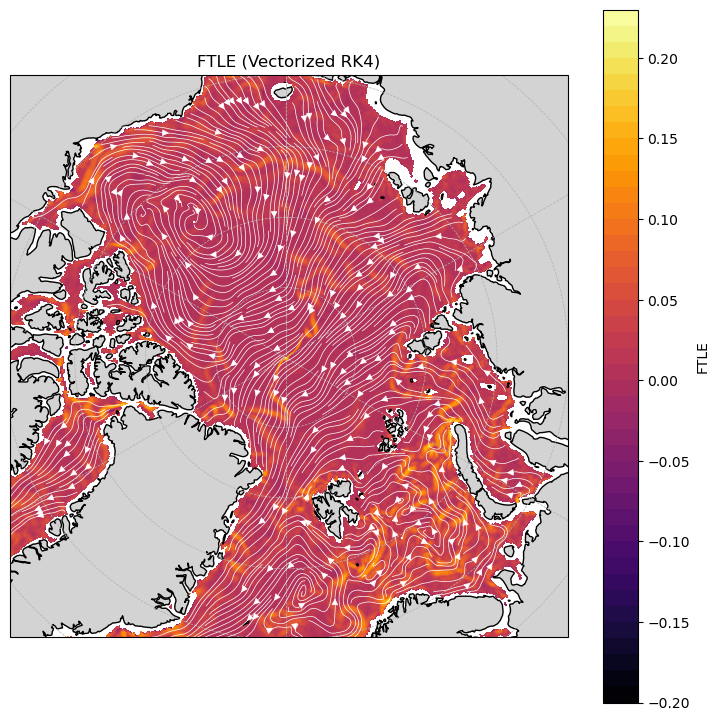

In [74]:

# -------------------------------------------------
# 5. Plot
# -------------------------------------------------
proj_map = ccrs.NorthPolarStereo()
proj_data = ccrs.PlateCarree()  # your grid is lat-lon

fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection=proj_map)

ax.set_extent([-180, 180, 70, 90], crs=proj_data)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='--')

# FTLE field
cf = ax.contourf(
    x, y, FTLE,
    levels=50,
    cmap='inferno',
    transform=proj_data,
)


# Streamlines
ax.streamplot(
    x, y, u, v,
    color='white',
    density=5,
    linewidth=0.5,
    transform=proj_data   # <<< CRITICAL
)

plt.colorbar(cf, ax=ax, label='FTLE')
plt.title("FTLE (Vectorized RK4)")
plt.show()

